# NBD - Data center module | Challenge 2: workload balancing

## Floyd group

### Importing libraries and loading data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random as rdm
import math
from tqdm import tqdm
from distfit import distfit
import pickle

In [2]:
data = pd.read_csv('Cell_a.csv')
data = data[data['CPU']!=0]
data['Arrival_Time'] = data['Arrival_Time']/1e6

In [3]:
data

,Job_ID,Task_ID,Arrival_Time,CPU,Memory
0,375000667413,0,6.030263e+02,0.041851,0.001169
1,375000669289,0,6.064130e+02,0.024968,0.001179
2,375000670586,0,6.089945e+02,0.024176,0.001173
3,375000670588,0,6.089945e+02,0.019552,0.001163
4,375000670590,0,6.090429e+02,0.028044,0.001179
...,...,...,...,...,...
2329127,400465207745,0,2.678935e+06,0.004677,0.000067
2329128,400465219425,0,2.678944e+06,0.000343,0.000004
2329129,400465219425,1,2.678944e+06,0.000557,0.000004
2329130,400465256347,0,2.678955e+06,0.002459,0.000050


### Explorative data analysis

In [4]:
data['CPU'].describe()

count    2.282872e+06
mean     4.042883e+00
std      1.370927e+02
min      9.536743e-07
25%      2.730942e-02
50%      7.698393e-02
75%      2.746394e-01
max      5.278707e+04
Name: CPU, dtype: float64

Assuming an underlying bounded Pareto process for the task size, we wanted to estimate a maximum likelihood estimator for the value of $\alpha$ through a repeated subsampling. 

In [ ]:
alpha = []
M = 1000
S = 1000
dist = distfit(distr='genpareto')
cpu = np.array(data['CPU'])
for i in range(M):
    subsample = cpu[np.random.randint(0,len(cpu),size=S)]
    alpha.append(dist.fit_transform(subsample)['model']['params'][0])

In [6]:
np.mean(alpha)

1.1967717767694361

Retrieving some statistics

In [7]:
global_var = data['CPU'].var()

min_load = data['CPU'].min()
max_load = data['CPU'].max()

ranging = (min_load, max_load)

In [8]:
count = data.groupby('Job_ID')["Task_ID"].count()
data = data.merge(count, on='Job_ID')

In [10]:
max_multi = data[data['Task_ID_y']!=0]['CPU'].max()
min_multi = data[data['Task_ID_y']!=0]['CPU'].min()
inner_multi_var = data[data['Task_ID_y']!=0]['CPU'].var()

max_single = data[data['Task_ID_y']==1]['CPU'].max()
min_single = data[data['Task_ID_y']==1]['CPU'].min()
inner_single_var = data[data['Task_ID_y']==1]['CPU'].var()

In [11]:
N = pd.unique(data['Job_ID']).shape[0]
one_task = data[data['Task_ID_y']==1].shape[0]
multi_task = data[data['Task_ID_y']>1].shape[0]
props = {'Fraction of one-task-jobs':one_task/N,
         'Fraction of multi-task jobs':multi_task/N}

stat = pd.Series({
    'Global variance':global_var,
    'Range':list(ranging),
    'Fraction of single-task-jobs': one_task/N,
    'Fraction of multi-task-jobs':multi_task/N,
    'Single-task max': max_single,
    'Single-task min': min_single,
    'Inner variance in single-task group': inner_single_var,
    'Multi-task job max': max_multi,
    'Multi-task job min': min_multi,
    'Inner variance in multi-task group': inner_multi_var
})

In [12]:
jobs = pd.unique(data['Job_ID'])
temp = {job:k for (job,k) in zip(jobs, count)}

multitask = [job for job in jobs if temp[job]>1]

In [13]:
new_stat = pd.Series({
    'Variance of total CPU required':inner_multi_var,
    'Max value for total CPU required':max_multi,
    'Min value for total CPU required':min_multi
})

____________________

# Baseline implementation: LWL + FCFS

In [ ]:
class FCFSServer:
    def __init__(self, id):
        self.id = id
        self.workload = 0
        self.queue = []
        self.mu = 0.1
        self.inactivity = 0
    
    def enqueue(self, task):
        new_job_id = str(int(task["Job_ID"]))+ "_" + str(int(task["Task_ID"]))
        arrival_time = task["Arrival_Time"]
        service_time = (task["CPU"]/self.mu)     
        a_dict = {"id": new_job_id, "Arrival Time": arrival_time, "Service Time" : service_time}
        self.queue.append(a_dict)

In [ ]:
class LWLDispatcher:
    def __init__(self, N, init, duration):
        self.N = N
        self.farm = [FCFSServer(i) for i in range(self.N)]
        self.clock = init
        self.duration = duration
        self.register = []
        self.mu = 0.1

    def clock_update(self, task):
        self.clock = task['Arrival_Time']

    def workload_inactivity_update(self, task):
        delta = task['Arrival_Time'] - self.clock
        for i in range(self.N):
            U = self.farm[i].workload
            self.farm[i].workload = max([0, U-(delta)])
            self.farm[i].inactivity -= min([0, U-(delta)])
        
    def queue_manager(self, task):
        active_queues = [server for server in self.farm if len(server.queue)>0]
        if len(active_queues) != 0:
            for server in active_queues:
                queue = server.queue
                now = task['Arrival_Time']
                delta = now-self.clock
                while delta > 0 and len(queue) > 0:
                    active = queue[0]
                    if active['Service Time'] - delta <= 0:
                        self.register.append({'Job:':active['id'].split('_')[0],
                                            'Task:':active['id'].split('_')[1],
                                            'Arrived at': active['Arrival Time'],
                                            'Completed at:': now+active['Service Time']-delta})
                        server.queue.pop(0)
                        delta -= active['Service Time']
                        queue = server.queue
                    else:
                        active['Service Time'] -= delta
                        break
    
    def dispatch(self, task):
        workload = np.array([server.workload for server in self.farm])
        pointed = np.argmin(workload)
        server_ = self.farm[pointed]
        server_.enqueue(task)
        server_.workload += task['CPU']/self.mu
        
    
    def closing(self):
        active_queues = [k for k in range(self.N) if len(self.farm[k].queue)>0]
        if len(active_queues) == 0:
            return True
        else:
            for i in active_queues:
                Q = self.farm[i].queue
                jobs = [task['id'].split('_')[0] for task in Q]
                for j in range(len(jobs)):
                    job = jobs[j]
                    service = Q[j]['Service Time']
                    self.register.append({'Job:':Q[j]['id'].split('_')[0],
                                            'Task:':Q[j]['id'].split('_')[1],
                                            'Completed at:': Q[j]['Arrival Time']+service})                
                    if len(jobs[j:]) > 1:
                            Q[j+1]['Service Time'] += service
                    else:
                        break
    
    def utilization(self):
        uts = {}
        for i in range(self.N):
            uts[i] = 1 - self.farm[i].inactivity/self.duration
        return uts

In [ ]:
#Main pipeline
duration = data.iloc[data.shape[0]-1,2]-data.iloc[0,2]
start = data.iloc[0,2]

baseline = LWLDispatcher(64, start, duration)
for q in tqdm(range(data.shape[0])):
    task = data.iloc[q,].to_dict()
    baseline.workload_inactivity_update(task)
    baseline.queue_manager(task)
    baseline.dispatch(task)
    baseline.clock_update(task)
baseline.closing()

In [ ]:
jobs = [dic['Job:'] for dic in baseline.register]
task = [dic['Task:'] for dic in baseline.register]
completion = [dic['Completed at:'] for dic in baseline.register]

output = pd.DataFrame({
    'Job':jobs,
    'Task':task,
    'Completion Time':completion
})

In [ ]:
output.to_pickle('baseline.pkl')

base_uts = baseline.utilization()
with open('base_uts.pickle', 'wb') as handle:
    pickle.dump(base_uts, handle, protocol=pickle.HIGHEST_PROTOCOL)

________________________

# Custom design: SITA-E(LWL) + FCFS

#### Balancing the thresholds

In [16]:
X = np.sort(data['CPU'])
quantum = sum(X)/64

In [22]:
quantum

144209.119797647

In [21]:
sum(X)

9229383.667049408

In [ ]:
groups = {i:np.array([]) for i in range(64)}
i = 1
k = 1
while i < 64:
    while np.sum(groups[i]) < quantum:
        groups[i] = np.append(groups[i], X[k])
        k += 1
    k += 1
    i += 1

In [ ]:
thresholds = {i:0 for i in range(64)}
for i in range(64):
    thresholds[i] = max(groups[i])

In [ ]:
def server_assign(task):
    i = 0
    while i < 63:
        if task['CPU'] >= thresholds[i]:
            i += 1
        else:
            break
    else:
        return i
    
servers_assignment = []
for q in tqdm(range(data.shape[0])):
    servers_assignment.append(server_assign(data.iloc[q,].to_dict()))

data['Clusters'] = np.array(servers_assignment)

#### Class for the SITA-E(LWL) dispatcher

In [ ]:
class SITAdispatcher:
    def __init__(self, N, init, duration):
        self.N = N
        self.farm = [FCFSServer(i) for i in range(self.N)]
        self.clock = init
        self.duration = duration
        self.register = []
        self.mu = 0.1

    def clock_update(self, task):
        self.clock = task['Arrival_Time']

    def inactivity_update(self, task):
        delta = task['Arrival_Time'] - self.clock
        for i in set(range(self.N)):
            U = self.farm[i].workload
            self.farm[i].inactivity -= np.min(np.array([0, U-(delta)]))
            self.farm[i].workload = max([0, U-(delta)])
        
    def queue_manager(self, task):
        active_queues = [server for server in self.farm if len(server.queue)>0]
        if len(active_queues) != 0:
            for server in set(active_queues):
                queue = server.queue
                now = task['Arrival_Time']
                delta = now-self.clock
                while delta > 0 and len(queue) > 0:
                    active = queue[0]
                    if active['Service Time'] - delta <= 0:
                        self.register.append({'Job:':active['id'].split('_')[0],
                                            'Task:':active['id'].split('_')[1],
                                            'Arrived at': active['Arrival Time'],
                                            'Completed at:': now+active['Service Time']-delta})
                        server.queue.pop(0)
                        delta -= active['Service Time']
                        queue = server.queue
                    else:
                        active['Service Time'] -= delta
                        break
    
    def dispatch(self, task, µ = 0.1):
        runn = (task["CPU"]/µ)
        pointed = int(task['Clusters'])
        if pointed == 0:
            if (self.farm[0].workload > self.farm[62].workload) and (self.farm[62].workload >= self.farm[63].workload):
                pointed = 63
            elif (self.farm[0].workload > self.farm[62].workload) and (self.farm[62].workload < self.farm[63].workload):
                pointed = 62
            else: 
                pointed = 0
        server_ = self.farm[pointed]
        server_.enqueue(task)
        self.farm[pointed].workload += runn
    
    def closing(self):
        active_queues = [k for k in range(self.N) if len(self.farm[k].queue)>0]
        if len(active_queues) == 0:
            return True
        else:
            for i in active_queues:
                Q = self.farm[i].queue
                jobs = [task['id'].split('_')[0] for task in Q]
                for j in range(len(jobs)):
                    job = jobs[j]
                    service = Q[j]['Service Time']
                    self.register.append({'Job:':Q[j]['id'].split('_')[0],
                                            'Task:':Q[j]['id'].split('_')[1],
                                            'Completed at:': Q[j]['Arrival Time']+service})                
                    if len(jobs[j:]) > 1:
                            Q[j+1]['Service Time'] += service
                    else:
                        break
    
    def utilization(self):
        uts = {}
        for i in range(self.N):
            uts[i] = 1 - self.farm[i].inactivity/self.duration
        return uts

In [ ]:
#Main pipeline
duration = data.iloc[data.shape[0]-1,2]-data.iloc[0,2]
start = data.iloc[0,2]

custom = SITAdispatcher(64, start, duration)
for q in tqdm(range(data.shape[0])):
    task = data.iloc[q,].to_dict()
    custom.inactivity_update(task)
    custom.queue_manager(task)
    custom.dispatch(task)
    custom.clock_update(task)
custom.closing()

In [ ]:
jobs = [dic['Job:'] for dic in custom.register]
task = [dic['Task:'] for dic in custom.register]
completion = [dic['Completed at:'] for dic in custom.register]

output = pd.DataFrame({
    'Job':jobs,
    'Task':task,
    'Completion Time':completion
})

In [ ]:
output.to_pickle('custom.pkl')

cust_uts = custom.utilization()
with open('cust_uts.pickle', 'wb') as handle:
    pickle.dump(cust_uts, handle, protocol=pickle.HIGHEST_PROTOCOL)

_________________

# Visualization

In [23]:
def ecdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

In [24]:
with open('./baseline.pkl','rb') as f1:
    base = pickle.load(f1)
with open("./custom.pkl",'rb') as f2:
    cust = pickle.load(f2)

In [25]:
arrival_times = data.groupby('Job_ID')['Arrival_Time'].min()

cust_completion_times = cust.groupby('Job')['Completion Time'].max()
cust_arrival_times = data.groupby('Job_ID')['Arrival_Time'].min()
cust_job_response_times = np.array(cust_completion_times)-np.array(arrival_times)

base_completion_times = base.groupby('Job')['Completion Time'].max()
base_arrival_times = data.groupby('Job_ID')['Arrival_Time'].min()
base_job_response_times = np.array(base_completion_times)-np.array(arrival_times)

In [26]:
cust_mean_job = np.mean(cust_job_response_times)
base_mean_job = np.mean(base_job_response_times)

In [27]:
base_mean_job

27603.901135085016

In [28]:
cust_mean_job

739.7719594786453

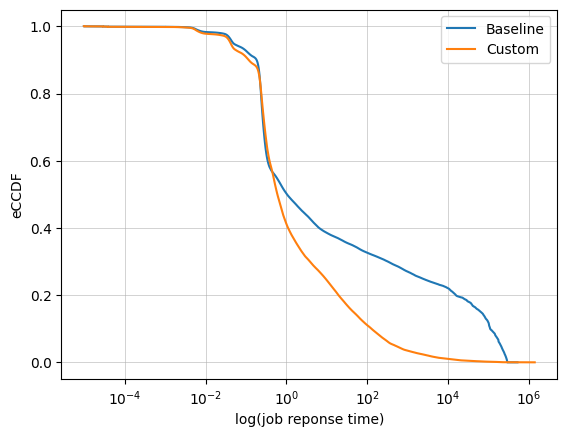

In [65]:
bq_t, bp_t = ecdf(base_job_response_times)
cq_t, cp_t = ecdf(cust_job_response_times)

plt.plot(bq_t, 1-bp_t, label='Baseline')
plt.plot(cq_t, 1-cp_t, label='Custom')

plt.xscale('log')
plt.xlabel('log(job reponse time)')
plt.ylabel('eCCDF')
plt.grid(linewidth=0.4)
plt.legend()

In [30]:
tot_cpu = data.groupby('Job_ID')['CPU'].sum()
tot_cpu = tot_cpu/0.1

base_slow_down = base_job_response_times/np.array(tot_cpu)
cust_slow_down = cust_job_response_times/np.array(tot_cpu)

base_mean_slow = np.mean(base_slow_down)
cust_mean_slow = np.mean(cust_slow_down)

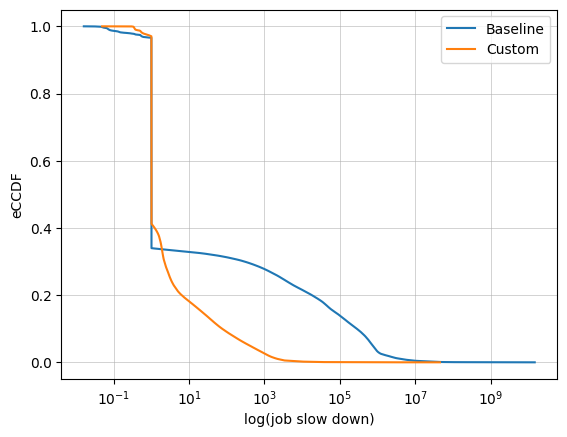

In [31]:
bq_s, bp_s = ecdf(base_slow_down)
cq_s, cp_s = ecdf(cust_slow_down)

plt.plot(bq_s, 1-bp_s, label='Baseline')
plt.plot(cq_s, 1-cp_s, label='Custom')
plt.xscale('log')
plt.xlabel('log(job slow down)')
plt.ylabel('eCCDF')
plt.grid(linewidth=0.4)
plt.legend()

In [32]:
with open('./base_uts.pickle','rb') as f1:
    base_uts = pickle.load(f1)
with open("./cust_uts.pickle",'rb') as f2:
    cust_uts = pickle.load(f2)

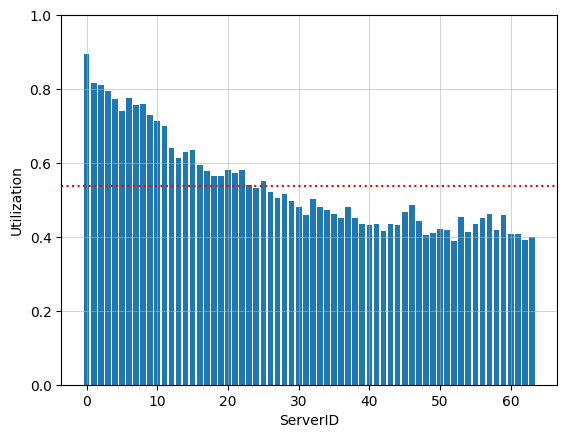

In [33]:
plt.bar(base_uts.keys(), base_uts.values())
plt.ylim((0,1))
plt.grid(linewidth=0.4)
plt.xlabel('ServerID')
plt.ylabel('Utilization')
plt.axhline(y=np.mean(np.array(list(base_uts.values()))), color='red', linestyle=':')

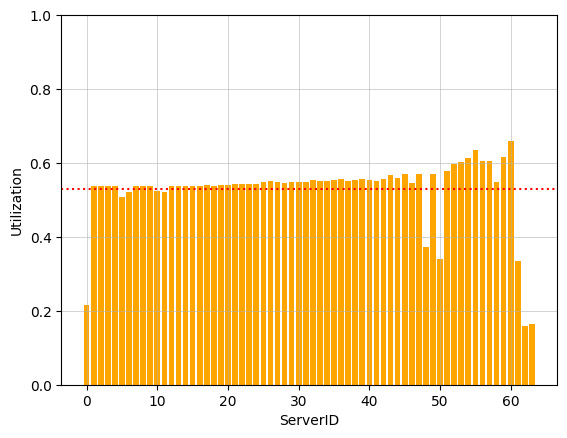

In [34]:
plt.bar(cust_uts.keys(), cust_uts.values(), color='orange')
plt.ylim((0,1))
plt.grid(linewidth=0.4)
plt.xlabel('ServerID')
plt.ylabel('Utilization')
plt.axhline(y=np.mean(np.array(list(cust_uts.values()))), color='red', linestyle=':')

In [35]:
cust_mean_job = np.mean(cust_job_response_times)
base_mean_job = np.mean(base_job_response_times)

mean_base_uts = np.mean(np.array(list(base_uts.values())))
mean_cust_uts = np.mean(np.array(list(cust_uts.values())))

base_mean_slow = np.mean(base_slow_down)
cust_mean_slow = np.mean(cust_slow_down)

base_load = 129
cust_load = (1752627*7 + data.shape[0]-1752627)/data.shape[0]

In [52]:
metrics = pd.DataFrame({
    'Mean Job Response Time': [round(base_mean_job,2),round(cust_mean_job,2)],
    'Mean Job Slow Down': [base_mean_slow,cust_mean_slow],
    'Mean utilization': [mean_base_uts,mean_cust_uts],
    'Mean Message Load': [int(base_load),round(cust_load,2)]
})

metrics.index = ['Baseline','Custom']

In [53]:
metrics

,Mean Job Response Time,Mean Job Slow Down,Mean utilization,Mean Message Load
Baseline,27603.90,1.241676e+06,0.538425,129.00
Custom,739.77,7.548976e+02,0.528506,5.61


In [ ]:
print